# Dicom loading and visualization

#### Cargar Archivos DICOM
Cargo los archivos DICOM desde el directorio especificado. Trabajo inicialmente con un subconjunto de los archivos para testear.

**¿Con que CT trabajo? No me ha quedado claro qué subconjunto de archivos usar!**
1) ct_directory = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008"
2) ct_directory_2 = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/2.000000-PRE LIVER-48636"



#### Libraries

In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import cv2
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


#### Aqui alojamos las funciones

In [88]:
def load_dicom_files(directory: str, file_extension: str = '.dcm'):
    """Load DICOM files from a specified directory that match the given file extension."""
    return [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith(file_extension)]
    
def sort_dicom_files_by_instance_number(dicom_files: List[pydicom.Dataset]) -> List[pydicom.Dataset]:
    """Sort DICOM files by the Instance Number."""
    return sorted(dicom_files, key=lambda x: int(x.InstanceNumber))

def sort_dicom_files_by_position(dicom_files):
    """Ordena archivos DICOM según la posición del paciente en la imagen."""
    return sorted(dicom_files, key=lambda x: float(x.ImagePositionPatient[2]))

def sort_dicom_files(dicom_files):
    """Sort DICOM files by available headers, only including those with AcquisitionNumber equal to 2."""
    def get_sort_key(file):
        # Define sorting key: ImagePositionPatient (converted to a sortable form)
        position_patient = getattr(file, 'ImagePositionPatient', None)
        if position_patient:
            position_patient = float(position_patient[2])
        return position_patient if position_patient else 0

    # Filter to include only files with AcquisitionNumber equal to 2 --> With 3D Slicer we have seen is the correct one
    filtered_files = [file for file in dicom_files if getattr(file, 'AcquisitionNumber', None) == '2']
    
    '''
    Primero ordena por AcquisitionNumber y, dentro de cada número de adquisición, 
    ordena por la posición del paciente a lo largo del eje Z (ImagePositionPatient[2]).'''
    # Sort the filtered files by ImagePositionPatient along the Z-axis
    return sorted(filtered_files, key=get_sort_key)


def check_acquisition_uniformity(dicom_files: List[pydicom.Dataset]):
    """Check if all DICOM files have the same 'Acquisition Number'."""
    acquisition_numbers = {img.AcquisitionNumber for img in dicom_files}
    if len(acquisition_numbers) > 1:
        print("Multiple acquisition numbers found. Ensure all CT images are from a single acquisition.")
    else:
        print("Only a single acquisition")
    
def get_pixel_arrays(dicom_files: List[pydicom.Dataset]) -> np.ndarray:
    """Extract pixel arrays from sorted DICOM files and stack them into a single numpy array."""
    return np.stack([file.pixel_array for file in dicom_files])

def display_images(ct_image, seg_image):
    """Display CT and Segmentation images side-by-side."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(ct_image, cmap='gray', aspect='auto')
    plt.title('CT Slice')

    plt.subplot(1, 2, 2)
    plt.imshow(seg_image, cmap='gray', aspect='auto')
    plt.title('Segmentation Slice')
    plt.show()

def create_mip(ct_volume: np.ndarray):
    """Create and visualize Maximum Intensity Projection (MIP) of a CT volume."""
    mip_axial = np.max(ct_volume, axis=0)
    mip_coronal = np.max(ct_volume, axis=1)
    mip_sagittal = np.max(ct_volume, axis=2)
    
    projections = [mip_axial, mip_coronal, mip_sagittal]
    titles = ['MIP Axial', 'MIP Coronal', 'MIP Sagittal']

    plt.figure(figsize=(15, 5))
    for i, mip in enumerate(projections):
        plt.subplot(1, 3, i + 1)
        vmin, vmax = np.percentile(mip, [2, 98])
        plt.imshow(mip, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def visualize_planes(ct_volume: np.ndarray):
    """Visualize axial, coronal, and sagittal planes of a CT volume."""
    coronal_plane = ct_volume[:, :, ct_volume.shape[2] // 2]
    sagittal_plane = ct_volume[:, ct_volume.shape[1] // 2, :]
    axial_plane = ct_volume[ct_volume.shape[0] // 2, :, :]
    
    plt.figure(figsize=(15, 5))
    for i, (plane, title) in enumerate(zip([axial_plane, coronal_plane, sagittal_plane],
                                           ['Axial Plane', 'Coronal Plane', 'Sagittal Plane'])):
        plt.subplot(1, 3, i+1)
        plt.imshow(plane, cmap='gray', aspect='auto', origin='lower')
        plt.title(title)
        plt.axis('off')
    plt.show()

def apply_window(image: np.ndarray, window_center: int, window_width: int) -> np.ndarray:
    """Apply window leveling to an image based on the given center and width."""
    lower_bound = window_center - 0.5 * window_width
    upper_bound = window_center + 0.5 * window_width
    return np.clip((image - lower_bound) / window_width, 0, 1)

def separate_segmentations(data):
    number_of_segments = 4 
    fig, axes = plt.subplots(1, number_of_segments, figsize=(15, 10))

    for i in range(number_of_segments):
        segment = data[i, :, :]
        ax = axes[i]
        ax.imshow(segment, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Segment {i+1}')

    plt.show()

In [17]:
# Data paths
# Windows
#ct_directory = "C:/Users/pedromarti/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/03-14-1998-NA-CT ABDOMEN WWO CONT-48924/4.000000-Recon 2 3 PHASE LIVER ABD-87008"
#seg_directory = "C:/Users/pedromarti/Documents/GitHub/Medial_Image_Pydicom/HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm"

# Mac
ct_directory = "HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/4.000000-Recon 2 LIVER 3 PHASE AP-28011/"
seg_directory = "HCC_007/manifest-1643035385102/HCC-TACE-Seg/HCC_007/12-27-1997-NA-AP LIVER PRT WWO-67834/300.000000-Segmentation-39839/1-1.dcm"


### Cargamos las imagenes y las ordenamos

Cargamos y ordenamos las imagenes CT. Como ya hemos visto en el 3D Slicer, cogemos la acquisition number 2.

In [59]:
# Load and process DICOM CT images
ct_files = load_dicom_files(ct_directory)
sorted_ct_files = sort_dicom_files(ct_files)


Cargamos la segmentation image

In [105]:
# Load and process segmentation image
dicom_segmentation = pydicom.dcmread(seg_directory)
segmentation_image = dicom_segmentation.pixel_array

Simple visualización para saber que todo ha ido bien

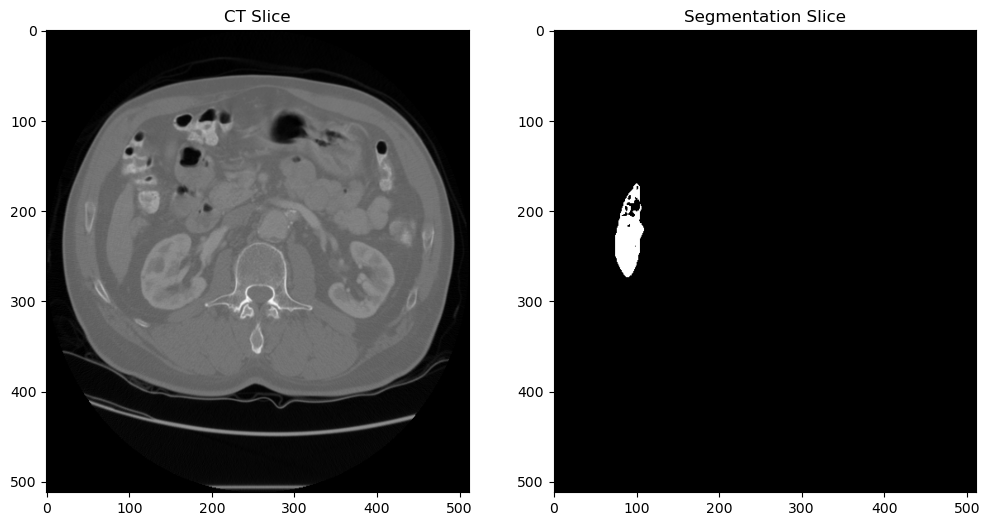

In [106]:
# Visualize a slice of CT and Segmentation images
ct_images = get_pixel_arrays(sorted_ct_files)
display_images(ct_images[8], segmentation_image[8])


Como sabemos que tiene 4 regiones en la segmentación y 300 registros, dividimos 300/4 y así sabemos que cada región tiene 75 registros.

In [126]:
# Cargamos los registros a su region
img_liver = segmentation_image[0:74,:,:]
img_mass = segmentation_image[75:149,:,:]
img_portal_vein = segmentation_image[150:224,:,:]
img_abdominal_aorta = segmentation_image[225:300,:,:]

# Lo convertimos en una imagen
# Define colores para cada región (BGR en OpenCV)
color_liver = (0, 255, 0)   # Verde
color_mass = (0, 0, 255)    # Rojo
color_portal_vein = (255, 0, 0)   # Azul
color_abdominal_aorta = (255, 255, 0)  # Amarillo

# Crea imágenes RGB vacías
img_color_liver = np.zeros((img_liver.shape[0], img_liver.shape[1], 3), dtype=np.uint8)
img_color_mass = np.zeros((img_mass.shape[0], img_mass.shape[1], 3), dtype=np.uint8)
img_color_portal_vein = np.zeros((img_mass.shape[0], img_mass.shape[1], 3), dtype=np.uint8)
img_color_abdominal_aorta = np.zeros((img_mass.shape[0], img_mass.shape[1], 3), dtype=np.uint8)

# Copia los valores de cada array a los canales RGB correspondientes
img_color_liver[img_liver > 0] = color_liver
img_color_mass[img_mass > 0] = color_mass
img_color_portal_vein[img_portal_vein > 0] = color_portal_vein
img_color_abdominal_aorta[img_abdominal_aorta > 0] = color_abdominal_aorta

# Combina las imágenes (usa un modo de fusión adecuado)
img_superpuesta = cv2.add(img_color_liver, img_color_mass)
img_superpuesta = cv2.add(img_superpuesta, img_color_portal_vein)
img_superpuesta = cv2.add(img_superpuesta, img_color_abdominal_aorta)

# Muestra la imagen superpuesta
cv2.imshow('Imagen Superpuesta', img_superpuesta)
cv2.waitKey(0)
cv2.destroyAllWindows()


IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 512

#### Estudio de encabezados

In [22]:
# Print details and dimensions
print("Details of CT images sorted by Image Position Patient:")
for img in sorted_ct_files:
    print(f"Acquisition Number: {img.AcquisitionNumber}, Image Position Patient: {img.ImagePositionPatient}")

print("Dimensiones del arreglo de segmentación:", segmentation_image.shape)
print("Dimensiones del arreglo de imágenes CT:", ct_images.shape)

Details of CT images sorted by Image Position Patient:
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -240.000000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -237.500000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -235.000000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -232.500000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -230.000000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -227.500000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -225.000000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -222.500000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -220.000000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -217.500000]
Acquisition Number: 2, Image Position Patient: [-192.500000, -180.000000, -

Ahora ya tenemos la acquisition que mejor queda con nuestra segmentación.

OLD:

Confirmamos que hay más de una adquisición

**Que hago aqui? Hay más de una adquisición pero solo debe haber una. En los obejtivos pone "Asegurar que solo haya una adquisicion".**

In [28]:
check_acquisition_uniformity(sorted_ct_files)

Only a single acquisition


#### Aplicamos windowing a las imagenes para mejorarlas

In [29]:
# Windowing parameters
window_center, window_width = 40, 400
windowed_ct_images = np.array([apply_window(img, window_center, window_width) for img  in ct_images])

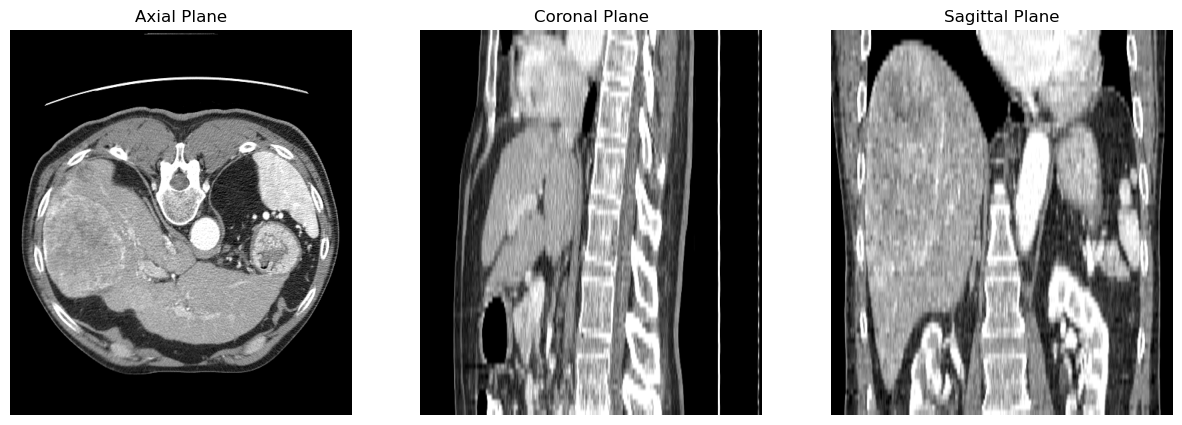

In [48]:
# Visualize different planes
visualize_planes(windowed_ct_images)

tab10 fr segmentation

In [139]:
# Cargamos los registros a su region
img_liver = segmentation_image[1:75,:,:]
img_mass = segmentation_image[76:150,:,:]
img_portal_vein = segmentation_image[151:225,:,:]
img_abdominal_aorta = segmentation_image[226:300,:,:]

img_segmented = (img_liver*1) + (img_mass*2) + (img_portal_vein*3) + (img_abdominal_aorta*4)

#### Prueba: Superposición de las CT sobre la segmentada 

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'add'
> Overload resolution failed:
>  - add() missing required argument 'src1' (pos 1)
>  - add() missing required argument 'src1' (pos 1)


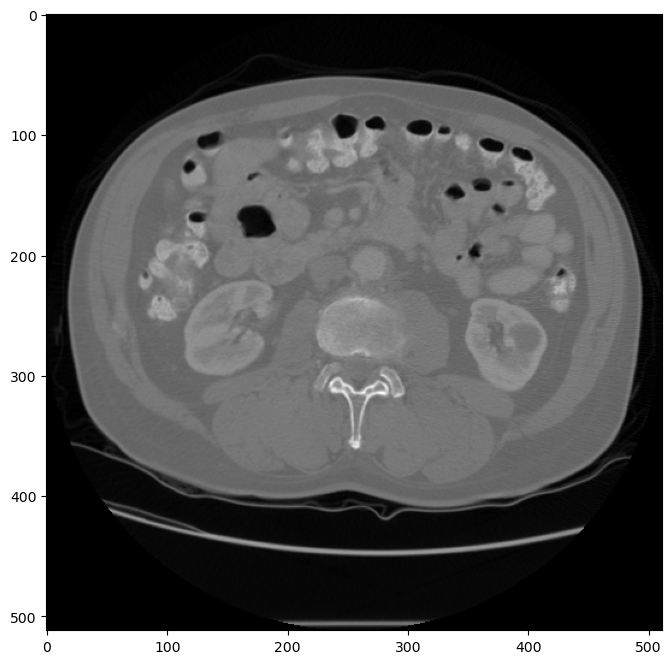

In [135]:
def visualize_ct_with_segmentation(ct_slice, segmented):
    
    # Crear figura y ejes
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(ct_slice, cmap='gray')  # Visualizar la imagen de CT en escala de grises
    
    # Configuración del colormap para la segmentación con transparencia
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, 256))
    colors[:, -1] = np.linspace(0, 0.3, 256)  # Configuración de la transparencia
    colored_cmap = matplotlib.colors.ListedColormap(colors)

    # Superponer la segmentación en la imagen de CT
    seg_im = ax.imshow(seg_slice, cmap=colored_cmap, interpolation='none')
    cv2.add()
    ax.set_title('CT Slice with Segmentation Overlay')
    plt.axis('off')
    plt.show()

# Iterar sobre cada slice en el conjunto de datos de CT y Segmentación
for i in range(5):
    ct_slice = ct_images[i]
    seg_slice = img_segmented[i]
    visualize_ct_with_segmentation(ct_slice, seg_slice)



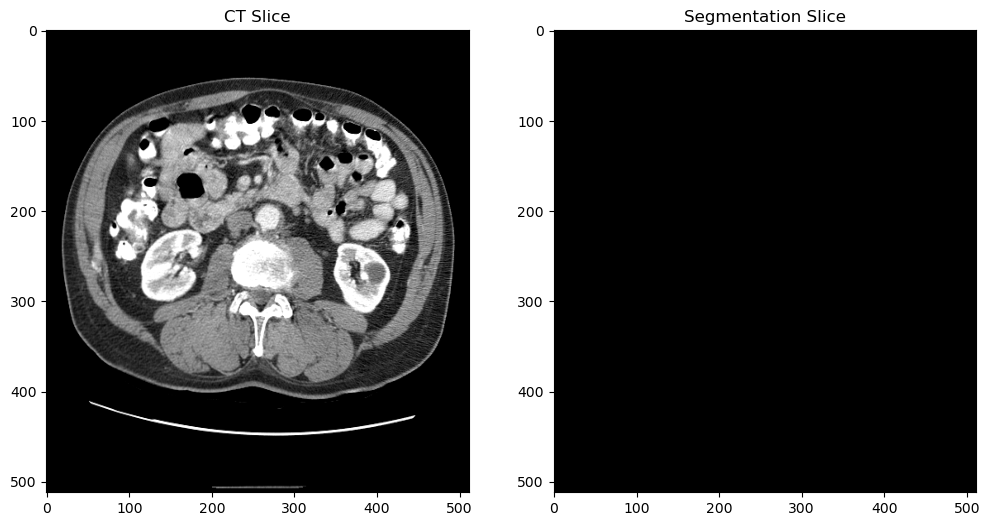

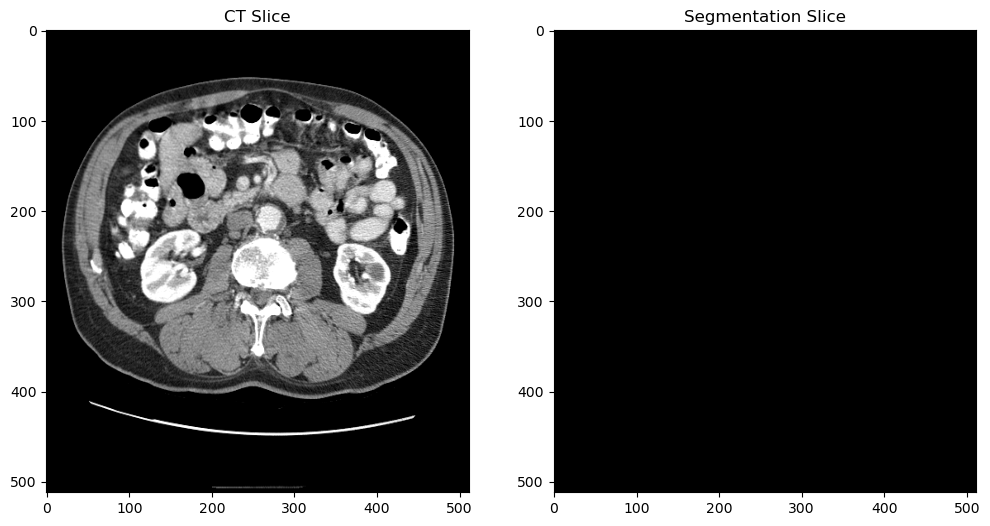

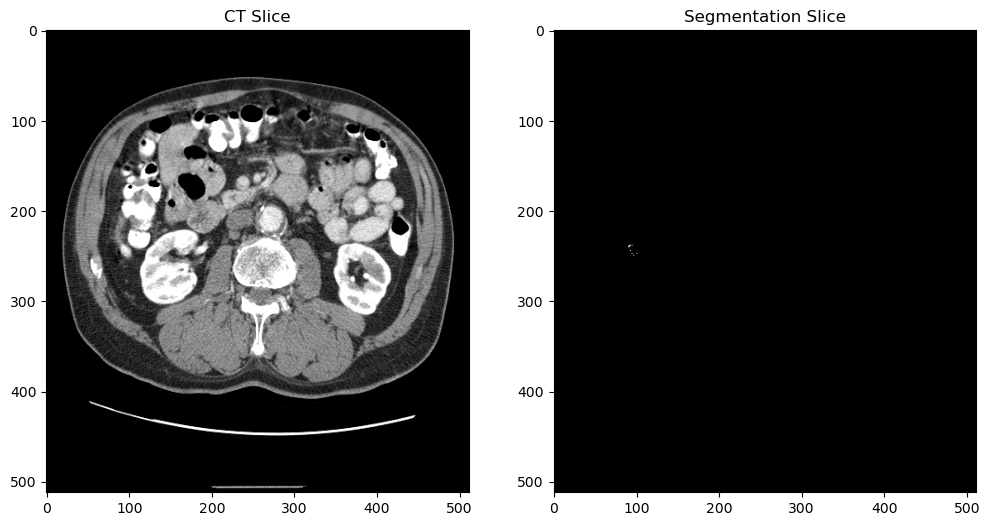

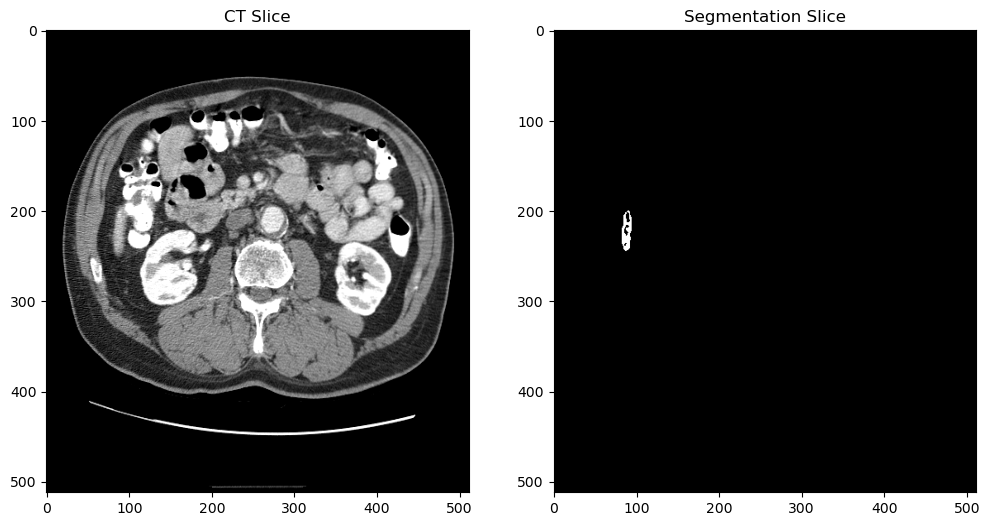

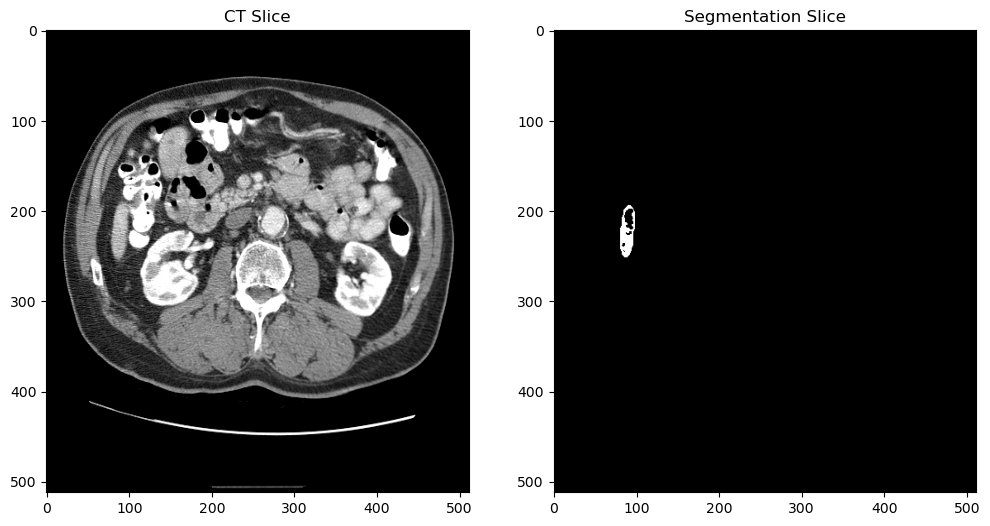

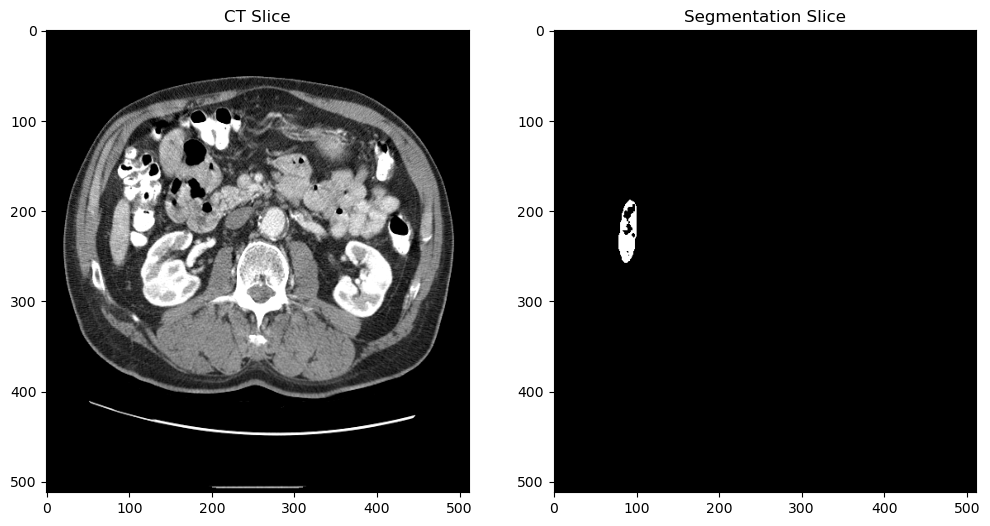

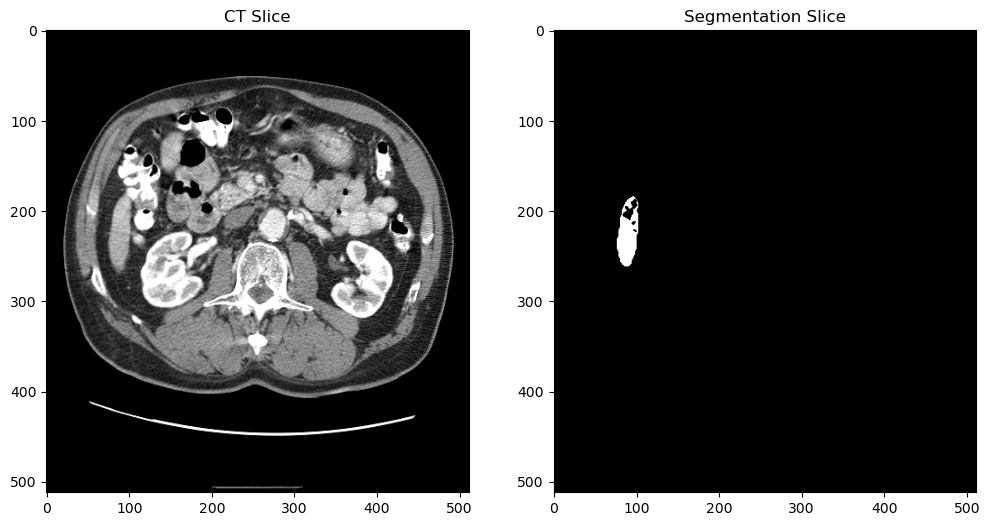

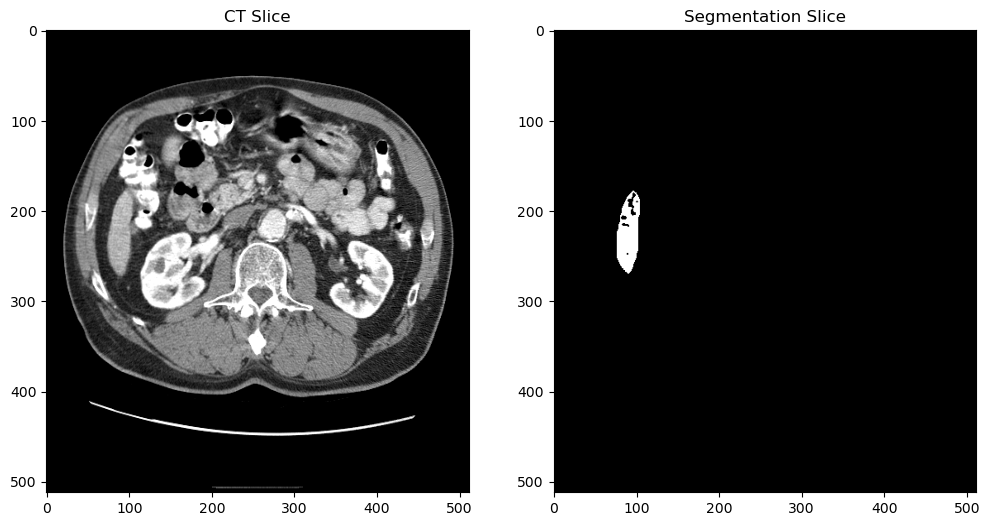

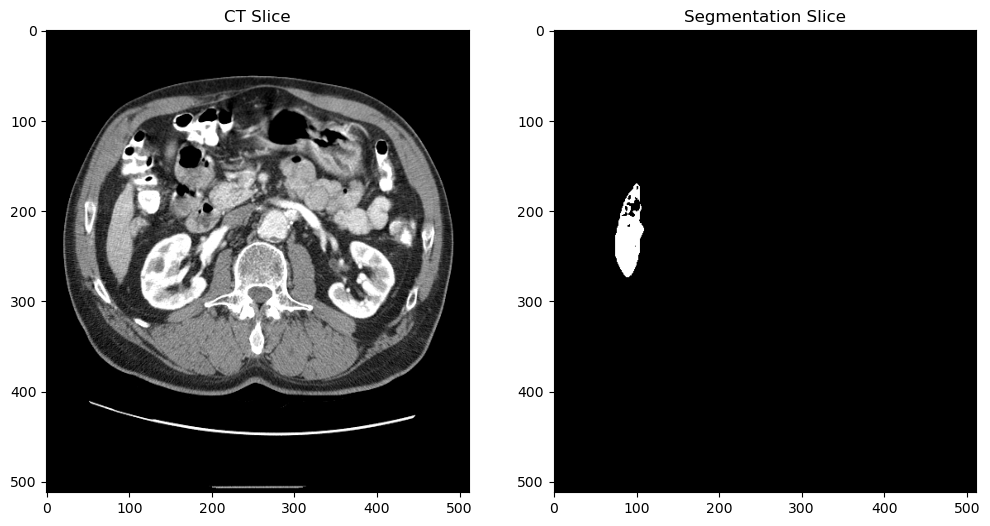

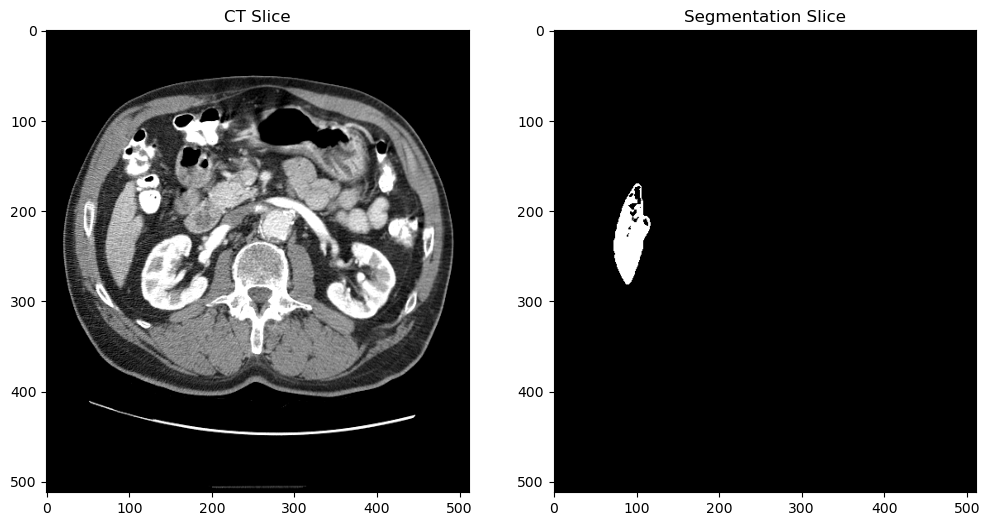

Segmentation array loaded with shape: (300, 512, 512)


In [73]:
# Visualize images and segmentations
for i in range(10):  # Example for the first 10 slices
    display_images(windowed_ct_images[i], segmentation_image[i])
print("Segmentation array loaded with shape:", segmentation_image.shape)

#### ROI

Estadísticas de la imagen:
Valor mínimo: 0.0, Valor máximo: 1.0
Media: 0.2165085220336914, Desviación estándar: 0.2696629915027511
Porcentaje de píxeles sobre el umbral: 25.47%
Número de ROIs detectadas: 208


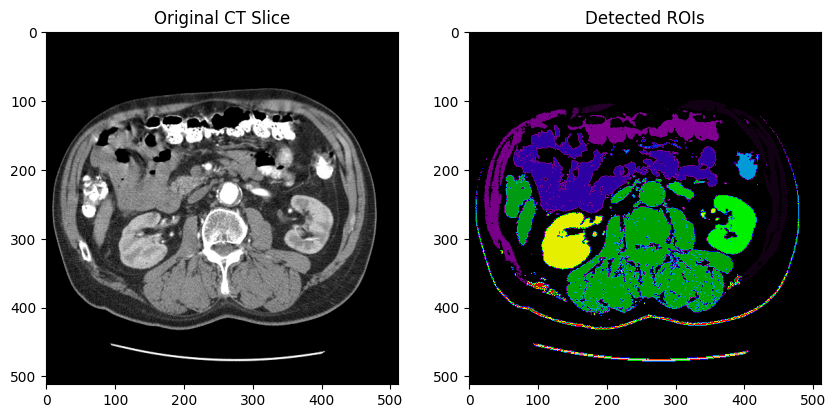

'\nunique, counts = np.unique(labels_im, return_counts=True)\nfor roi_label, count in zip(unique, counts):\n    if roi_label != 0:  # Excluyendo el fondo\n        print(f"ROI Label: {roi_label}, Pixel Count: {count}")\n'

In [186]:
def apply_threshold(ct_slice, threshold=0.1):
    """Aplicar umbralización para separar el ROI del fondo."""
    _, thresh = cv2.threshold(ct_slice, threshold, 255, cv2.THRESH_BINARY)
    return thresh
'''
PREGUNTA: Tenemos que excluir aquellas zonasa que son demasiado pequeñas?
 Se podría implementar un filtro por tamaño,
 conservando solo las ROIs que tengan un número mínimo de píxeles, 
 lo que indica que son regiones significativas.
 
 Ej. unique, counts = np.unique(labels_im, return_counts=True)
     filtered_labels = np.zeros_like(labels_im)
     for label, count in zip(unique, counts):
        if count > min_pixel_count:  # Filtrar ROIs pequeñas
            filtered_labels[labels_im == label] = label
'''
def find_rois(thresh_image): 
    """Encontrar y etiquetar ROIs en la imagen umbralizada."""
    num_labels, labels_im = cv2.connectedComponents(thresh_image.astype(np.uint8))
    return num_labels, labels_im

def visualize_rois(ct_slice, labels_im):
    """Visualizar las ROIs sobre la imagen original."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_slice, cmap='gray')
    plt.title('Original CT Slice')
    plt.subplot(1, 2, 2)
    plt.imshow(labels_im, cmap='nipy_spectral')
    plt.title('Detected ROIs')
    plt.show()

ct_slice = windowed_ct_images[0]

# Análisis de datos de la imagen
print("Estadísticas de la imagen:")
print(f"Valor mínimo: {np.min(ct_slice)}, Valor máximo: {np.max(ct_slice)}")
print(f"Media: {np.mean(ct_slice)}, Desviación estándar: {np.std(ct_slice)}")

# Procesamiento
threshold = 0.43
thresh = apply_threshold(ct_slice, threshold)
print(f"Porcentaje de píxeles sobre el umbral: {np.sum(thresh > 0) / thresh.size * 100:.2f}%")

num_labels, labels_im = find_rois(thresh)
print(f"Número de ROIs detectadas: {num_labels - 1}")  # Excluyendo el fondo

# Visualización
visualize_rois(ct_slice, labels_im)

# Análisis de componentes conectados
'''
unique, counts = np.unique(labels_im, return_counts=True)
for roi_label, count in zip(unique, counts):
    if roi_label != 0:  # Excluyendo el fondo
        print(f"ROI Label: {roi_label}, Pixel Count: {count}")
'''

#### MIP

In [114]:
def verify_alignment(ct_dcm, seg_dcm):
    """Verify if the DICOM files have matching slice locations."""
    if hasattr(ct_dcm, 'SliceLocation') and hasattr(seg_dcm, 'SliceLocation'):
        if abs(ct_dcm.SliceLocation - seg_dcm.SliceLocation) > 0.1:  # Assuming a tolerance of 0.1
            print(f"Mismatch: CT {ct_dcm.SliceLocation} vs. Seg {seg_dcm.SliceLocation}")
            return False
        print("CT and Segmentation are aligned.")
        return True
    print("One or both files do not contain SliceLocation data for comparison.")
    return False

def visualize_ct_with_segmentation(ct_slice, seg_slice):
    """Visualize CT slice with segmentation overlay."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(ct_slice, cmap='gray')
    colored_cmap = create_transparent_cmap(plt.cm.viridis, 0.3)
    ax.imshow(seg_slice, cmap=colored_cmap, interpolation='none')
    ax.set_title('CT Slice with Segmentation Overlay')
    plt.axis('off')
    plt.show()

def create_transparent_cmap(cmap, transparency):
    """Create a colormap with transparency for overlay."""
    colors = cmap(np.linspace(0, 1, 256))
    colors[:, -1] = np.linspace(0, transparency, 256)
    return matplotlib.colors.ListedColormap(colors)

def calculate_mip(ct_volume, axis):
    """Calculate the Maximum Intensity Projection (MIP) along a given axis."""
    return np.max(ct_volume, axis=axis)

def calculate_and_display_mips(ct_volume):
    """Calculate MIPs for all three planes and display them with a lilac color theme."""
    mip_axial = calculate_mip(ct_volume, axis=0)
    mip_coronal = calculate_mip(ct_volume, axis=1)
    mip_sagittal = calculate_mip(ct_volume, axis=2)
    display_mip_images(mip_axial, mip_coronal, mip_sagittal)

def display_mip_images(mip_axial, mip_coronal, mip_sagittal):
    """Display MIP images for axial, coronal, and sagittal planes with customized color."""
    plt.figure(figsize=(18, 6))

    # Colormap personalizado que tiende al lila
    cmap = plt.get_cmap('twilight')

    # Definir los percentiles para ajustar los valores de visualización de cada MIP
    vmin_a, vmax_a = np.percentile(mip_axial, [2, 98])
    vmin_c, vmax_c = np.percentile(mip_coronal, [2, 98])
    vmin_s, vmax_s = np.percentile(mip_sagittal, [2, 98])

    # Axial
    plt.subplot(1, 3, 1)
    plt.imshow(mip_axial, cmap=cmap, aspect='auto', vmin=vmin_a, vmax=vmax_a, origin='lower')
    plt.title('MIP Axial')
    plt.axis('off')

    # Coronal
    plt.subplot(1, 3, 2)
    plt.imshow(mip_coronal, cmap=cmap, aspect='auto', vmin=vmin_c, vmax=vmax_c, origin='lower')
    plt.title('MIP Coronal')
    plt.axis('off')

    # Sagittal
    plt.subplot(1, 3, 3)
    plt.imshow(mip_sagittal, cmap=cmap, aspect='auto', vmin=vmin_s, vmax=vmax_s, origin='lower')
    plt.title('MIP Sagittal')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

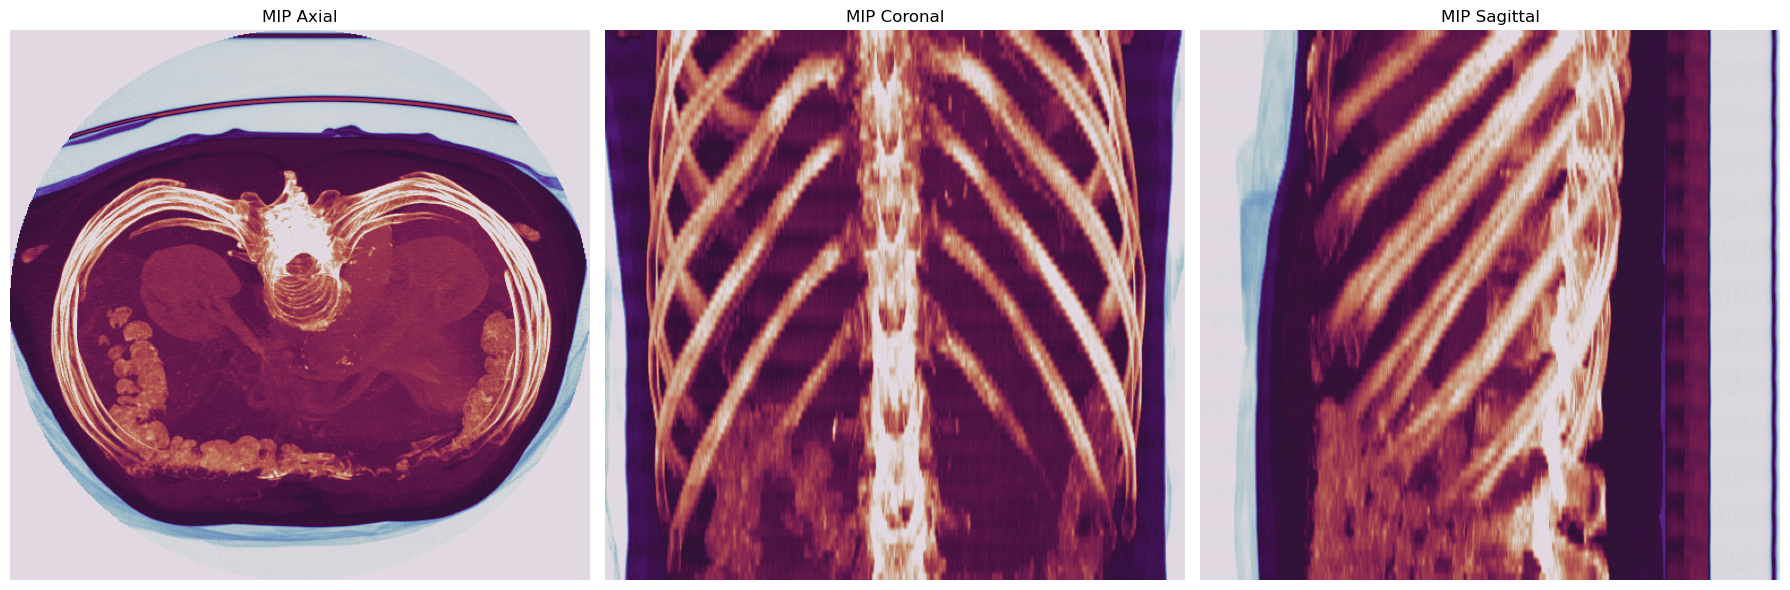

In [115]:
# Example usage within your data processing pipeline:
'''for ct_dcm, seg_dcm in zip(ct_images, segmentation_image):
    if verify_alignment(ct_dcm, seg_dcm):
        visualize_ct_with_segmentation(ct_dcm.pixel_array, seg_dcm.pixel_array)'''

calculate_and_display_mips(ct_images)

#### 3D

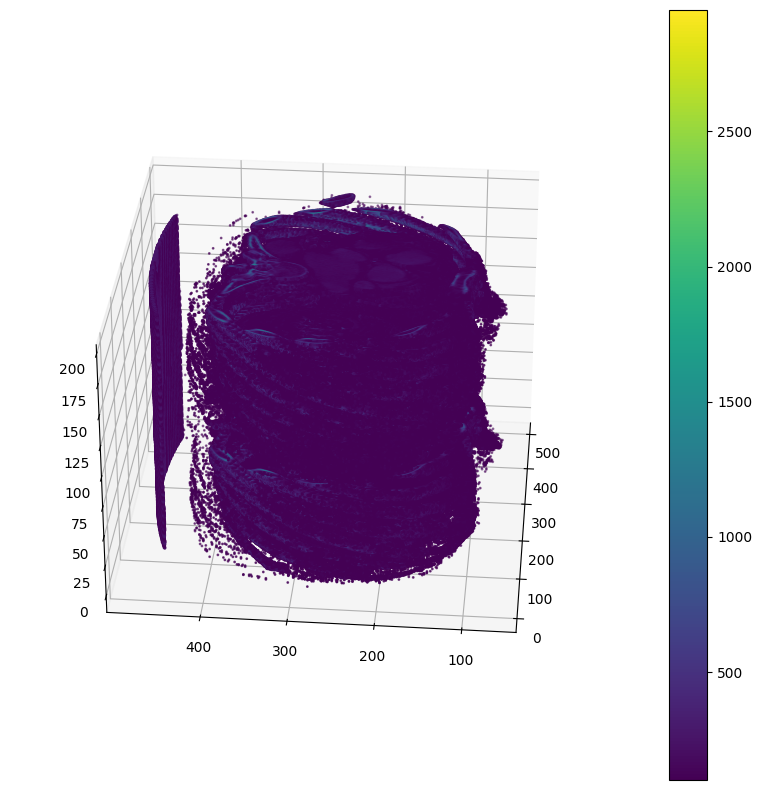

In [194]:
def plot_3d(image, threshold=-300, rotation_angle=360, interval=50):
    """Plot 3D visualization of CT data."""
    p = image.transpose(2, 1, 0)
    p = p.clip(min=threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos = np.where(p > threshold)
    scat = ax.scatter(pos[0], pos[1], pos[2], c=p[pos], cmap='viridis', s=1)
    ax.view_init(30, 185)
    ani = FuncAnimation(fig, lambda frame: ax.view_init(30, frame), frames=np.arange(0, rotation_angle, 2), interval=interval)
    plt.colorbar(scat, ax=ax, orientation='vertical')
    plt.show()
    return ani

plot_3d(ct_images, threshold=100)  # Adjust threshold as needed

# Image Coregistration

#### Cargamos las Imagenes DICOM

In [15]:
from pydicom import dcmread
import pylibjpeg
from scipy.optimize import minimize

In [5]:
reference_image_path = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
input_images_path = "C:/Users/Pedro/Documents/GitHub/Medial_Image_Pydicom/Project/RM_Brain_3D-SPGR"

In [9]:
input_images = sort_dicom_files_by_position(load_dicom_files(input_images_path))
reference_image = dcmread(reference_image_path)

In [11]:
# Convert to numpy arrays for processing
input_images_np = np.stack([img.pixel_array for img in input_images])
reference_image_np = reference_image.pixel_array

In [12]:
print("Loaded reference image shape:", reference_image_np.shape)
print("Loaded input image stack shape:", input_images_np.shape)

Loaded reference image shape: (193, 229, 193)
Loaded input image stack shape: (212, 512, 512)


#### Coregistration

In [35]:
'''
For handle rotations -->  multiply_quaternions & conjugate_quaternion
'''
def multiply_quaternions(
        q1: tuple[float, float, float, float],
        q2: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0]
    )

def conjugate_quaternion(
        q: tuple[float, float, float, float]
        ) -> tuple[float, float, float, float]:
    """ Multiply two quaternions, expressed as (1, i, j, k). """
    return (q[0], -q[1], -q[2], -q[3])

'''
For move and rotate images or points based on quaternion computations --> translation and axial_rotation
'''
def translation(
        point: tuple[float, float, float],
        translation_vector: tuple[float, float, float]
        ) -> tuple[float, float, float]:
    """ Perform translation of `point` by `translation_vector`. """
    x, y, z = point
    v1, v2, v3 = translation_vector
    return (x+v1, y+v2, z+v3)

def axial_rotation(
        point: tuple[float, float, float],
        angle_in_rads: float,
        axis_of_rotation: tuple[float, float, float]) -> tuple[float, float, float]:
    """ Perform axial rotation of `point` around `axis_of_rotation` by `angle_in_rads`. """
    x, y, z = point
    v1, v2, v3 = axis_of_rotation

    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(v1**2 + v2**2 + v3**2)
    v1, v2, v3 = v1 / v_norm, v2 / v_norm, v3 / v_norm

    # Quaternion associated to point.
    p = (0, x, y, z)

    # Quaternion associated to axial rotation.
    cos, sin = math.cos(angle_in_rads / 2), math.sin(angle_in_rads / 2)
    q = (cos, sin * v1, sin * v2, sin * v3) #Rotation cuaternion

    # Quaternion associated to image point
    q_star = conjugate_quaternion(q)
    p_prime = multiply_quaternions(q, multiply_quaternions(p, q_star))

    # Interpret as 3D point (i.e. drop first coordinate)
    return p_prime[1:] # Here we rerturn only the x,y,z components

''' 
For apply combined transformations sequentially --> translation_then_axialrotation
'''
def translation_then_axialrotation(point: tuple[float, float, float], parameters: tuple[float, ...]):
    """ Apply to `point` a translation followed by an axial rotation, both defined by `parameters`. """
    x, y, z = point
    t1, t2, t3, angle_in_rads, v1, v2, v3 = parameters

    # Normalize axis of rotation to avoid restrictions on optimizer
    v_norm = math.sqrt(sum([coord ** 2 for coord in [v1, v2, v3]]))
    v1, v2, v3 = v1/v_norm, v2/v_norm, v3/v_norm

    x, y, z = translation(point=(x, y, z), translation_vector=(t1, t2, t3))
    x, y, z = axial_rotation(point=(x, y, z), angle_in_rads=angle_in_rads, axis_of_rotation=(v1, v2, v3))
    return x, y, z

''' 
For measure the alignment of two images (Finding the best alignment param) --> mutual_information [Similarity metric]
'''
def mutual_information(img_input: np.ndarray, img_reference) -> np.ndarray:
    """ Compute the Shannon Mutual Information between two images. """
    nbins = [10, 10]

    # Compute entropy of each image
    hist = np.histogram(img_input.ravel(), bins=nbins[0])[0] # histogram --> Array of weights
    prob_distr = hist / np.sum(hist)
    entropy_input = -np.sum(prob_distr * np.log2(prob_distr + 1e-7)) # 1e-7 --> Avoid 0 (calc errors)
    hist = np.histogram(img_reference.ravel(), bins=nbins[0])[0]
    prob_distr = hist / np.sum(hist)
    entropy_reference = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))

    # Compute joint entropy
    joint_hist = np.histogram2d(img_input.ravel(), img_reference.ravel(), bins=nbins)[0]
    prob_distr = joint_hist / np.sum(joint_hist)
    joint_entropy = -np.sum(prob_distr * np.log2(prob_distr + 1e-7))

    # Compute mutual information
    return entropy_input + entropy_reference - joint_entropy

""" 
Tranformation function
"""
def apply_transformation(image, tx, ty, tz, angle, axis):
    transformed_image = np.float32(image) # Convert image to float for transformations
    transformed_image = translation(transformed_image, (tx, ty, tz))
    transformed_image = axial_rotation(transformed_image, angle, axis)
    return transformed_image

def coregister_images(ref_img, input_img):
    # Define the objective function for optimization
    def objective(params):
        tx, ty, tz, angle, ax, ay, az = params
        transformed = apply_transformation(input_img, tx, ty, tz, angle, (ax, ay, az))
        return -mutual_information(ref_img, transformed)

    # Initial parameters: tx, ty, tz, angle, ax, ay, az
    initial_params = [0, 0, 0, 0, 1, 0, 0]
    result = minimize(objective, initial_params, method='Nelder-Mead')  # Minimize --> Se puede usar¿? Aplicamos el método nosotros a mano?
    return result

In [36]:
result = coregister_images(reference_image_np, input_images_np[0])
print("Optimization result:", result)

ValueError: too many values to unpack (expected 3)

#### Visualization of Talamus Region